# DSCI 417 - Project 03
## Forest Cover Prediction
**Malcolm Nichols**

## Part A: Set up Enviroment
In this part we will import the required tools from pyspark and create a SparkSession object

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.getOrCreate()

## Part B: Load and Explore the Data
In this project we will be working with the forest cover dataset, goal is to generate predictions about the type of forest cover in a particular wilderness region. We will start by loading the dataset into a DataFrame.

In [0]:
forest_schema = ('Elevation INT, Aspect INT, Slope INT, Horizontal_Distance_To_Hydrology INT, Vertical_Distance_To_Hydrology INT,'
                 'Horizontal_Distance_To_Roadways INT, Hillshade_9am INT, Hillshade_Noon INT, Hillshade_3pm INT,'
                 'Horizontal_Distance_To_Fire_Points INT, Wilderness_Area STRING, Soil_Type INT, Cover_Type INT')

fc = (
    spark.read
    .option('delimiter', '\t')
    .option('header', True)
    .schema(forest_schema)
    .csv('/FileStore/tables/forest_cover.txt')
)

fc.printSchema()

root
-- Elevation: integer (nullable = true)
-- Aspect: integer (nullable = true)
-- Slope: integer (nullable = true)
-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
-- Vertical_Distance_To_Hydrology: integer (nullable = true)
-- Horizontal_Distance_To_Roadways: integer (nullable = true)
-- Hillshade_9am: integer (nullable = true)
-- Hillshade_Noon: integer (nullable = true)
-- Hillshade_3pm: integer (nullable = true)
-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
-- Wilderness_Area: string (nullable = true)
-- Soil_Type: integer (nullable = true)
-- Cover_Type: integer (nullable = true)

We will now look at the first few rows of the DataFrame, due to the columns being very wide we will break them down into two pieces to fit on the screen.

In [0]:
col_list = fc.columns

fc.select(col_list[:6]).show(3)
fc.select(col_list[6:]).show(3)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
 2596| 51| 3| 258| 0| 510|
 2590| 56| 2| 212| -6| 390|
 2804| 139| 9| 268| 65| 3180|
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
only showing top 3 rows

+-------------+--------------+-------------+----------------------------------+---------------+---------+----------+
Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area|Soil_Type|Cover_Type|
+-------------+--------------+-------------+----------------------------------+---------------+---------+----------+
 221| 232| 148| 6279| Rawah| 29| 5|
 220| 235| 151| 6225| Rawah| 29| 5|
 234| 238| 135| 6121| Rawah| 12| 2|
+-------------+--------------+-------------+----------------------------------+---------------+---------+----------+
only showing top 3 rows

Next we will determine the number of observations in the dataset

In [0]:
N = fc.count()
print(N)

15120

Now to determine the proportions of records in each of the two label categories

In [0]:
(
    fc
    .groupBy('Cover_Type')
    .agg(
        expr(f'ROUND(COUNT(*)/{N},4) as prop')
    )
    .show()
)

+----------+------+
Cover_Type| prop|
+----------+------+
 1|0.1429|
 6|0.1429|
 3|0.1429|
 5|0.1429|
 4|0.1429|
 7|0.1429|
 2|0.1429|
+----------+------+

## Part C: Preprocessing and Splitting the Data
We will now create the stages to be used in our preprocessing pipeline

In [0]:
cat_features = ['Wilderness_Area', 'Soil_Type']
num_features = [c for c in col_list[:-1] if c not in cat_features]

ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]

feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)

encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features, dropLast=False)

assembler_lr = VectorAssembler(inputCols=num_features + vec_features, outputCol='features_lr')

assembler_dt = VectorAssembler(inputCols=num_features + ix_features, outputCol='features_dt')

Next we will create a pipeline from the stages above and apply it to our data

In [0]:
preprocessor =  Pipeline(stages=[feature_indexer, encoder, assembler_lr, assembler_dt]).fit(fc)
fc_train = preprocessor.transform(fc)
fc_train.persist()

fc_train.select('features_dt', 'Cover_Type').show(5, truncate=False)

+-----------------------------------------------------------------------+----------+
features_dt |Cover_Type|
+-----------------------------------------------------------------------+----------+
[2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,2.0,1.0] |5 |
[2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,2.0,1.0] |5 |
[2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,2.0,20.0] |2 |
[2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,2.0,6.0]|2 |
[2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,2.0,1.0] |5 |
+-----------------------------------------------------------------------+----------+
only showing top 5 rows

We will now split our model by setting aside 20% to form a test set and the remaining 80% to form a training set.

In [0]:
splits = fc_train.randomSplit([0.8, 0.2], seed=1)
train = splits[0]
test = splits[1]

train.persist()
print('Training Observations: ', train.count())
print('Testing Ovservations:  ', test.count())

Training Observations: 12118
Testing Ovservations: 3002

## Part D: Hyperparameter for Logistic Regression
Next to create an accuracy evaluator to be used for the tuning.

In [0]:
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='Cover_Type', metricName='accuracy')

We will now use grid search and cross-validation to perform the tuning.

In [0]:
logreg = LogisticRegression(featuresCol='features_lr', labelCol='Cover_Type')

param_grid = (ParamGridBuilder()
              .addGrid(logreg.regParam, [0.00001, 0.0001, 0.001, 0.01, 0.1])
              .addGrid(logreg.elasticNetParam, [0, 0.5, 1])
             ).build()

cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=accuracy_eval,
                    numFolds=5, seed=1)
cv_model = cv.fit(train)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

We will now identify the optimal model found by the grid search algorithm

In [0]:
lr_model = cv_model.bestModel

opt_regParam = lr_model.getRegParam()
opt_enetParam = lr_model.getElasticNetParam()

print('Max CV Score:  ', round(max(cv_model.avgMetrics),4))
print('Optimal Lambda:', opt_regParam)
print('Optimal Alpha: ', opt_enetParam)

Max CV Score: 0.6739
Optimal Lambda: 1e-05
Optimal Alpha: 0.0

Next we will generate a plot to display the results of the cross-validation

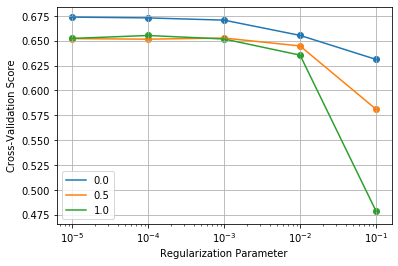

In [0]:
model_params = cv_model.getEstimatorParamMaps()

lr_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    lr_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(lr_cv_summary_list, columns=['reg_param', 'enet_param', 'acc'])

for en in cv_summary.enet_param.unique():
    sel = cv_summary.enet_param == en
    plt.plot(cv_summary.reg_param[sel], cv_summary.acc[sel], label=en)
    plt.scatter(cv_summary.reg_param[sel], cv_summary.acc[sel])

plt.legend()
plt.xscale('log')
plt.grid()
plt.xlabel('Regularization Parameter')
plt.ylabel('Cross-Validation Score')
plt.show()

## Part E: Hyperparameter Tuning for Decision Trees
We will now use grid search and cross-validation to perform hyperparameter tuning for decision trees.

In [0]:
dtree = DecisionTreeClassifier(featuresCol='features_dt', labelCol='Cover_Type', seed=1, maxBins=38)

param_grid = (ParamGridBuilder()
              .addGrid(dtree.maxDepth, range(4,26,2) )
              .addGrid(dtree.minInstancesPerNode, [1, 2, 4])
             ).build()

dt_cv = CrossValidator(estimator=dtree, estimatorParamMaps=param_grid, numFolds=5, 
                    evaluator=accuracy_eval, seed=1)

cv_model = dt_cv.fit(train)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

Next we will identify the optimal model found by the grid search algorithm

In [0]:
dt_model = cv_model.bestModel
opt_maxDepth = dt_model.getMaxDepth()
opt_minInstancesPerNode = dt_model.getMinInstancesPerNode()

print('Max CV Score:   ', round(max(cv_model.avgMetrics),4))
print('Optimal Depth:  ', opt_maxDepth)
print('Optimal MinInst:', opt_minInstancesPerNode)

Max CV Score: 0.7775
Optimal Depth: 16
Optimal MinInst: 1

Now to generate a plot to display the results of the cross-validation

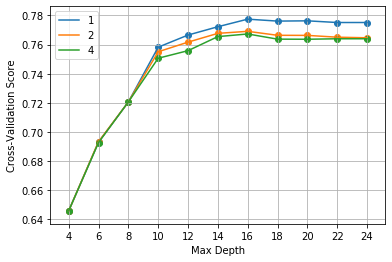

In [0]:
model_params = cv_model.getEstimatorParamMaps()

dt_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    dt_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(dt_cv_summary_list, columns=['maxDepth', 'minInst', 'acc'])

for mi in cv_summary.minInst.unique():
    sel = cv_summary.minInst == mi
    plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi)
    plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel]) 
    
plt.legend()
plt.grid()
plt.xticks(range(4,26,2))
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Score')
plt.show()

Next, we will display the feature importance for each of the features used in our optimal decision tree model.

In [0]:
features = num_features + cat_features

pd.DataFrame({
    'feature':features,
    'importance':dt_model.featureImportances
})

Out[16]:

,feature,importance
0,Elevation,0.394260
1,Aspect,0.048116
2,Slope,0.026453
3,Horizontal_Distance_To_Hydrology,0.078278
4,Vertical_Distance_To_Hydrology,0.036748
5,Horizontal_Distance_To_Roadways,0.070875
6,Hillshade_9am,0.025840
7,Hillshade_Noon,0.023199
8,Hillshade_3pm,0.017314
9,Horizontal_Distance_To_Fire_Points,0.079365


## Part F: Identifying and Evaluating the Final Model
We will now see which of the two models created prior have better performance on out-of-sample observations

I believe the dt_model will perform best on the out-of-sample observations, this is shown in the examples above where the score for the lr_model is 0.6739 or roughly 67.4%. While the score for the dt_model is 0.7775 or roughly 77.8%. We can also take into account how each model calculates it's probability. So Logistic Regression does this by first calculating a linear function and then passing the values (result) to the sigmoid function. While a Decision Tree applies a divide-and-conquer stategy, where it goes over a sequence of if-else tests and when a test is done it influences the next test and so on. So theoritically DT are doing more calculations against the data, and therefore has a better chance at working with certain data.

Next we will use our optimal model to generate predictions for the test set

In [0]:
test_pred = dt_model.transform(test)

test_pred.select(['probability', 'prediction', 'Cover_Type']).show(10, truncate=False)

+------------------------------------------------------------------------------+----------+----------+
probability |prediction|Cover_Type|
+------------------------------------------------------------------------------+----------+----------+
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |6 |
[0.0,0.0,0.0273972602739726,0.3150684931506849,0.0,0.0,0.6575342465753424,0.0]|6.0 |6 |
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |6 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.0,0.0,0.09375,0.0,0.0,0.90625,0.0] |6.0 |6 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |6 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |3 |
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |6 |
+------------------------------------------------------------------------------+----------+----------+
only showing top 10 rows

Using MulticlassMetrics we will use the test predictions to evaluate the final model's performance on out-of-sample data.

In [0]:
pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['Cover_Type'])))

metrics = MulticlassMetrics(pred_and_labels)
print('Test Set Accuracy: ', round(metrics.accuracy,4))

Test Set Accuracy: 0.7818

We will now display the confusion matric for the test data

In [0]:
cm = metrics.confusionMatrix().toArray().astype(int)
labels = [1, 2, 3, 4, 5, 6, 7]

pd.DataFrame(
    data=cm,
    columns=labels,
    index=labels
)

Out[19]:

,1,2,3,4,5,6,7
1,311,90,2,0,13,5,36
2,101,220,12,0,58,11,3
3,1,10,306,23,13,78,0
4,0,1,22,423,0,25,0
5,9,26,3,0,364,4,0
6,1,4,58,13,5,319,0
7,19,7,0,0,2,0,404


We will now identify the cell in which has the largest number of misclassifications.
  
Observations in the test set with **Cover Type 2** were misclassified by the model as **Cover Type 1** a total of **101 times**. This was the most common type of misclassification in the test set.

Next we will display the precision and recall for all seven label classes

In [0]:
print('Label   Precision   Recall')
print('--------------------------')
for lab in labels:
    print(f'{lab:<8}{metrics.precision(lab):<8.4f}{metrics.recall(lab):>10.4f}')

Label Precision Recall
--------------------------
1 0.7036 0.6805
2 0.6145 0.5432
3 0.7593 0.7100
4 0.9216 0.8981
5 0.8000 0.8966
6 0.7217 0.7975
7 0.9120 0.9352

1. Cover_Type 7, not only is its precision high (even though it is not the highest, off by 0.1) its recall is the highest. So it has the best chance of being correctly classified by our final model (Precision = 0.9129, Recall = 0.9352)
2. Cover_Type 2, with a precision of 0.6145 and a recall of 0.5432 it is not that confident enough to correctly classify that cover type.
3. Cover_type 5 has the greatest difference between the two. It's precision value deals with probability for a positive prediction, so for type 5 there is an 80% chance the model will coorectly predict the correct value. As for the recall it deals with a positive observation, so the model has a roughly 90% chance to correctly classify the observation for this cover type.